# Scatter Analysis

In this notebook, we study the scatter for a faint and a bright galaxy selection sample

In [1]:
import sys
sys.path.append("/home/s1/jesteves/copa_v2.1/")


In [2]:
from libs.main import copacabana
from libs.make_input_files.make_input_datasets import *

import pandas as pd
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata
import numpy as np
import matplotlib.pyplot as plt

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using Modified sklearn.mixture.GMM, modified to allow data weights


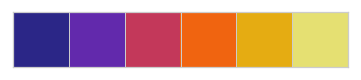

In [3]:
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.palplot(sns.color_palette("CMRmap"))

In [4]:
sys.path.append("/home/s1/jesteves/git/ccopa/notebooks/")
from myplots import *

In [5]:
## colors
blue = '#2E86C1'
gray = '#A6ACAF'
red = '#A93226'

### Loading Input Catalog

In [6]:
cfg = '../libs/config_copa_dc2.yaml'
copa = copacabana(cfg)

run   ='emuBPZ-rhod-zw-dmag1'
run2  ='emuBPZ-rhod-zw'

cat   = copa.load_copa_out('cluster',run=run)
cat2  = copa.load_copa_out('cluster',run=run2)

In [7]:
cat = cat

In [8]:
zcls  = cat['redshift']
r200  = cat['R200']
#nbkg  = cat['Nbkg']

ngals = cat['Ngals']
mu    = cat['MU'] 
muErr = cat['MU_ERR_JK']

#nbkgt = cat['Nbkg_true']
ngalst= cat['Ngals_true']
mut   = cat['MU_TRUE']
mutErr= cat['MU_TRUE_ERR_JK']

# m200  = cat['M200_true']
# r200t = cat['R200_true']

In [9]:
def scatter_jk(x):
    return np.nanstd(x)

def jackknife(x, func):
    """Jackknife estimate of the estimator func"""
    n = len(x)
    idx = np.arange(n)
    return np.sum(func(x[idx!=i]) for i in range(n))/float(n)

def jackknife_var(x, func):
    """Jackknife estiamte of the variance of the estimator func."""
    n = len(x)
    idx = np.arange(n)
    j_est = jackknife(x, func)
    return (n-1)/(n + 0.0) * np.sum((func(x[idx!=i]) - j_est)**2.0 for i in range(n))

def get_scatter_error(x,ns=10):
    x_jk     = scatter_jk(x)
    #x_jk_err = jackknife_var(x, scatter_jk)
    return x_jk

def get_scatter(x,xt):
    residual     = x/xt
    log_residual = np.log10(residual)
    
    check    = np.logical_not(np.isnan(residual))&np.logical_not(np.isinf(residual))
    mask     = remove_outliers(residual,n=2)&(check)
    
    bias            = 10**np.nanmean(log_residual[mask])
    log_scatter     = get_scatter_error(log_residual[mask])
    scatter         = 10**(log_scatter)-1
    
    out_fraction    = 1-1.*np.count_nonzero(mask)/len(x)
    return bias, scatter, out_fraction, mask

In [10]:
res = get_scatter(ngals,ngalst)

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [11]:
res[2]

0.07587548638132291

### Overall Accuracy

In [12]:
w = np.where(ngalst>1)[0]
residual = np.log10(ngals[w]/ngalst[w])

res  = get_scatter(ngals[w],ngalst[w])
xm   = res[0]
xstd = res[1]
of   = res[2]
mask = res[3]

print(r'mean: %.3f'%(xm))
print(r'rms : %.3f'%(xstd))
print(r'out. frac. : %.3f'%(of))

mean: 0.970
rms : 0.176
out. frac. : 0.065


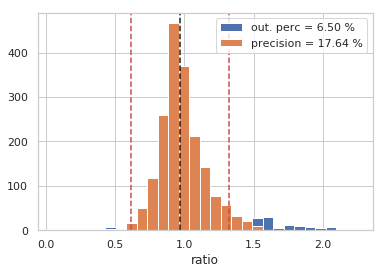

In [13]:
check     = np.logical_not(np.isnan(residual))&np.logical_not(np.isinf(residual))
xmin,xmax = 0.05, 2.25
xbins = np.linspace(xmin,xmax,30)
# xbins = np.linspace(np.log10(xmin),np.log10(xmax),30)
_ = plt.hist(10**residual[check],bins=xbins,label='out. perc = %.2f %%'%(100*of))
_ = plt.hist(10**residual[mask],bins=xbins,label=r'precision = %.2f %%'%(100*xstd))
plt.axvline(xm,color='k',ls='--')
plt.axvline(xm+2*xstd,color='r',ls='--')
plt.axvline(xm-2*xstd,color='r',ls='--')

# plt.yscale('log')
plt.xlabel('ratio')
plt.legend()

### Scaling Relations

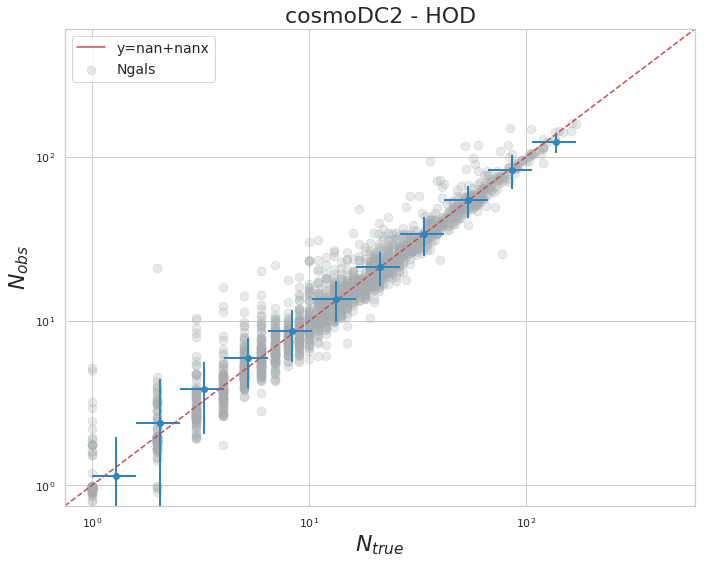

In [14]:
plot_scaling_relation(ngalst,ngals,title='cosmoDC2 - HOD',xlims=(0.75,600),fit=True)

In [15]:
mu2 = cat2['MU']

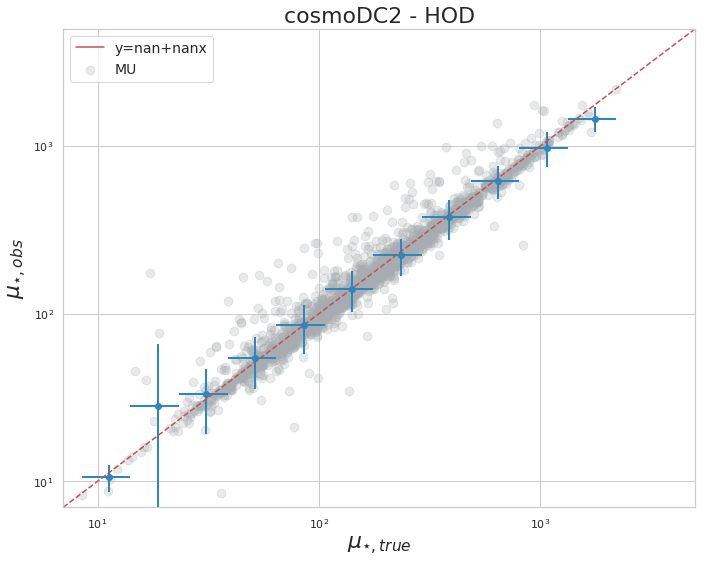

In [16]:
plot_scaling_relation(mut,mu,xl=r'$\mu_{\star,true}$',yl=r'$\mu_{\star,obs}$',title='cosmoDC2 - HOD',xlims=(7,5000),fit=True)

#### Residuals

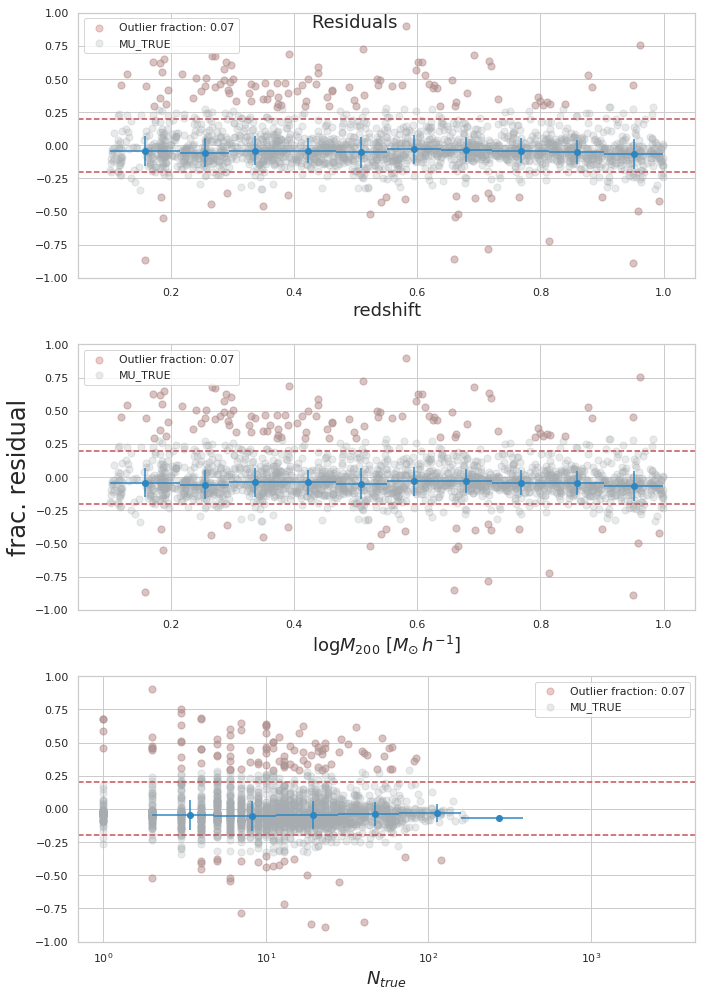

In [20]:
plot_triple_pannel(zcls,ngalst,zcls,mu,mut,ymax=1.,save=None)

In [18]:
yl = r'$ n_{bkg}^{copa} /n_{bkg}^{true} $'
plot_four_pannel(zcls,r200,ngalst,m200,nbkgt,nbkg,ylabel=yl)

NameError: name 'm200' is not defined

In [ ]:
w , =np.where((cat2['redshift']<=0.35)|(cat2['redshift']>=0.6))

In [21]:
w, = np.where(cat2['redshift']<=1)

In [22]:
x1 = cat['Ngals']
x2 = cat['Ngals_true']

x3 = cat2['Ngals'][w]
x4 = cat2['Ngals_true'][w]

y1 = cat['MU']
y2 = cat['MU_TRUE']

y3 = cat2['MU'][w]
y4 = cat2['MU_TRUE'][w]

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


Text(0.5,0,'$\\mu_{\\star}/\\mu_{\\star,true}$')

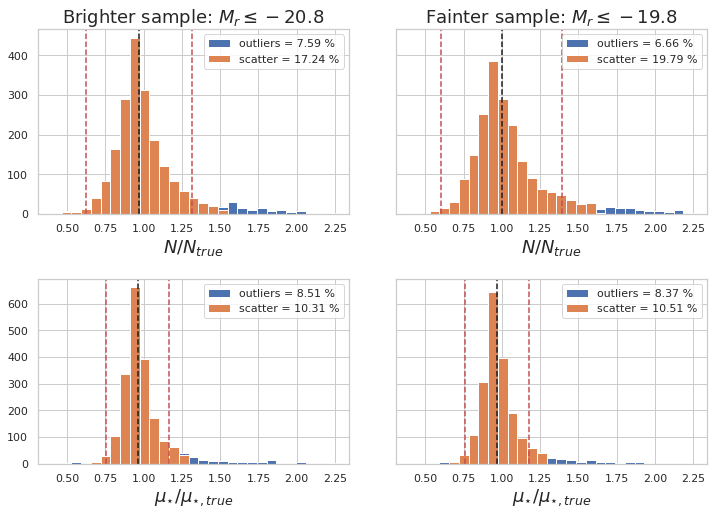

In [24]:
fig, ax = plt.subplots(2, 2, sharey='row', figsize=(12,8))
fig.subplots_adjust(hspace=0.35,wspace=0.15)

ax = ax.flatten(order='F')

plot_hist_residual(x1,x2,ax=ax[0])
plot_hist_residual(x3,x4,ax=ax[2])
plot_hist_residual(y1,y2,ax=ax[1])
plot_hist_residual(y3,y4,ax=ax[3])

ax[0].set_title('Brighter sample: $M_{r}\leq -20.8$',fontsize=18)
ax[2].set_title('Fainter sample: $M_{r}\leq -19.8$',fontsize=18)

label1 = r'$N/N_{true}$'
label2 = r'$\mu_{\star}/\mu_{\star,true}$'

ax[0].set_xlabel(label1,fontsize=18)
ax[2].set_xlabel(label1,fontsize=18)
ax[1].set_xlabel(label2,fontsize=18)
ax[3].set_xlabel(label2,fontsize=18)

#     ax[2].set_xlabel('R200')
#     ax[3].set_xlabel('Nbkg')
#     ax[1].set_xscale('log')
#     ax[2].set_xscale('log')
#     ax[0].set_ylim(ylims)

In [23]:
def plot_hist_residual(x,xt,ax=None):
    if ax is None: ax = plt.axes()

    residual = np.log10(x/xt)
    res  = get_scatter(x,xt)
    xm   = res[0]
    xstd = res[1]
    of   = res[2]
    mask = res[3]

    check     = np.logical_not(np.isnan(residual))&np.logical_not(np.isinf(residual))
    xmin,xmax = 0.4, 2.25
    xbins = np.linspace(xmin,xmax,30)
    # xbins = np.linspace(np.log10(xmin),np.log10(xmax),30)
    _ = ax.hist(10**residual[check],bins=xbins,label='outliers = %.2f %%'%(100*of))
    _ = ax.hist(10**residual[mask],bins=xbins,label=r'scatter = %.2f %%'%(100*xstd))
    ax.axvline(xm,color='k',ls='--')
    ax.axvline(xm+2*xstd,color='r',ls='--')
    ax.axvline(xm-2*xstd,color='r',ls='--')
    ax.legend()

In [ ]:
# def plot_four_pannel(zcls,r200,ntrue,nbkg,x1,x2,ylabel='y',ylims=(-2,2)):
#     fig, ax = plt.subplots(2, 2, sharey='all', figsize=(12,8))
#     fig.subplots_adjust(hspace=0.25,wspace=0.05)

#     ax = ax.flatten(order='F')

#     plot_residual(zcls ,x1,x2,ax=ax[0],log=True)
#     plot_residual(r200 ,x1,x2,ax=ax[2],log=True)
#     plot_residual(ntrue,x1,x2,ax=ax[1],log=True)
#     plot_residual(nbkg ,x1,x2,ax=ax[3],log=True)

#     ax[0].set_xlabel('redshift')
#     ax[1].set_xlabel('Ngals')
#     ax[2].set_xlabel('R200')
#     ax[3].set_xlabel('Nbkg')
#     ax[1].set_xscale('log')
#     ax[2].set_xscale('log')
#     ax[0].set_ylim(ylims)
#     ax[0].set_ylabel(ylabel,fontsize=22)
#     ax[1].set_ylabel(ylabel,fontsize=22)
